# Question 2

FashionMNIST is a public dataset of images. Downloading and preprocessing of FashionMNIST dataset is given as follows. Please design a Deep AutoEncoder model, compressing the data into a 2-dimensional space. Please draw the learned 2-dimensional representations with matplotlib. (50%)


In [1]:
# Note: Because of my poor computer power (dead kernel often occurs when using the downstream tsne.fit_transform), 
# In the model architecture, I directly compress the input images to 2 dimensional features in the encoding phase;
# rather than compress the input images to > 2 dimensional features in the encoding phase, and subsequently 
# use T-SNE to further reduce the dimentionality of features to 2.
# PS: I have discussed this problem with our course TA.

In [2]:
# Import packages
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [3]:
# Wrangle FashionMNIST dataset
train_data = torchvision.datasets.FashionMNIST(
    root='data/fashion_mnist/',
    train=True,                                     # Use training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W) 
                                                    # and normalize in the range [0.0, 1.0]
    download=False,                                 # Have already downloaded the FashionMNIST dataset, otherwise set download as True
)

In [4]:
# Check the dimensionality of features and labels in the training set
print(train_data.data.size())     
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


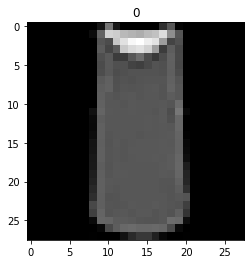

In [5]:
# Plot one example
plt.imshow(train_data.data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[2])
plt.show()

In [6]:
# Check the disctinctive labels
output = torch.unique(train_data.targets)
print(output)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [7]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (64, 1, 28, 28)
BATCH_SIZE = 64
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Model (25%)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),              # Have tried nn.Tanh; compared to nn.Tanh, nn.ReLU gives the reconstructed image more similar to the original image
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2),       # 2-D space: one axis represents one features and another axis represents another feature, which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),           # Compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
autoencoder = AutoEncoder()
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [10]:
# Set hyper-parameters
EPOCH = 10
LR = 0.005 # Learning rate is 0.005

In [11]:
# Set optimizer and loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [12]:
# Training (15%)
loss_list = []

for epoch in range(EPOCH): # Loop from 0 to 9 epochs
    
    loss_temp = 0
    i = 0
    
    for step, (x, b_label) in enumerate(train_loader): # Loop from each batch of input features and labels from trainloader during one epoch
        i += 1
        
        b_x = x.view(-1, 28*28)             # Batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)             # Batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # Mean square error
        optimizer.zero_grad()               # Clear gradients for this training step
        loss.backward()                     # Backpropagation, compute gradients
        optimizer.step()                    # Apply gradients
        
        loss_temp += loss.data.numpy()

    print("Epoch %s,  loss %.3f" % (epoch,  loss_temp/i))
    loss_list.append(loss_temp/i)           # Loss recoder

Epoch 0,  loss 0.038
Epoch 1,  loss 0.030
Epoch 2,  loss 0.029
Epoch 3,  loss 0.028
Epoch 4,  loss 0.028
Epoch 5,  loss 0.028
Epoch 6,  loss 0.027
Epoch 7,  loss 0.028
Epoch 8,  loss 0.028
Epoch 9,  loss 0.028


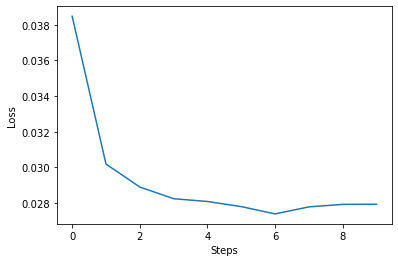

In [13]:
# Plot (10%)
# Visualize loss
plt.plot(loss_list)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [14]:
# Use the trained model and first 100 examples in the training set, to get compressed features 
view_data = train_data.data[:100].view(-1, 28*28).type(torch.FloatTensor)/255. # Normalization + flatten
encoded_data, decoded_data = autoencoder(view_data)

In [15]:
# Show the size of the encoded data
encoded_data.size()

torch.Size([100, 2])

In [16]:
# This compressed numpy-formatted feature set can be used for downstream tasks
encoded_arr = encoded_data.detach().numpy()
encoded_arr.shape

(100, 2)

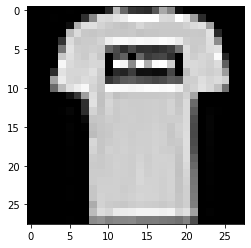

In [17]:
# This is the true data
plt.imshow(view_data.numpy()[1].reshape(28,28), cmap='gray')
plt.show()

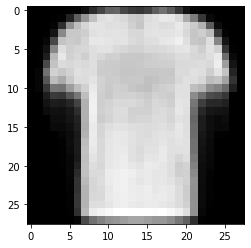

In [18]:
# This is the reconstructed data
plt.imshow(decoded_data.detach().numpy()[1].reshape(28,28), cmap='gray')
plt.show()

In [19]:
# This is the compressed feature 1
encoded_arr[:, 0]

array([-2.307583  ,  1.6388732 ,  1.2553657 ,  1.7723644 ,  3.003036  ,
       -1.8178272 , -0.00738832, -2.7036579 , -0.64248407, -1.4200708 ,
        1.7156643 , -3.8012853 , -0.36514106, -0.15183416,  0.40181273,
       -1.8676856 ,  3.0166295 ,  2.0527043 , -1.9547355 , -0.16336787,
        3.3500543 ,  2.508074  ,  0.12701058, -2.8199692 , -0.4256744 ,
        2.5410721 ,  1.4191937 , -2.333858  , -0.3494886 , -1.5983006 ,
        0.3237871 ,  1.8388209 , -0.81665635, -0.10130548,  0.5224501 ,
       -1.9865854 , -1.9326644 , -1.3750868 ,  3.617795  , -0.5799327 ,
       -1.1973976 , -0.129832  , -1.4180328 , -0.26300982, -3.6940665 ,
       -1.5325649 , -0.04155263,  2.789728  ,  1.3304724 ,  0.99476206,
        3.2362697 ,  3.0631685 , -0.12406307, -1.3746173 , -0.0173099 ,
        2.0562754 ,  1.8741529 ,  1.9017516 ,  3.352785  ,  2.4437957 ,
       -1.8406553 ,  1.1338723 ,  0.06716341,  0.33589408,  3.0388238 ,
       -2.666776  ,  1.8792244 ,  2.3644657 , -1.2798163 ,  2.21

In [20]:
# This is the compressed feature 2
encoded_arr[:, 1]

array([-0.03999567, -5.328668  , -1.5140038 , -2.7114708 , -3.6955583 ,
       -5.214967  ,  2.5294387 , -6.893132  , -0.27591783, -0.63924414,
       -4.613729  , -2.558909  ,  0.7912406 ,  1.1170983 ,  2.775308  ,
        0.25877333, -1.1021931 , -5.052081  , -5.3258557 , -1.7318516 ,
       -3.890714  , -0.8751001 , -3.8351734 ,  4.904698  , -5.836689  ,
       -4.2686987 , -4.2852077 , -6.8742723 , -3.8076293 , -5.9784017 ,
        1.0049683 , -1.8602641 , -4.9304276 , -0.5713261 , -0.9015785 ,
       -2.152819  , -2.3537354 , -3.0415597 , -2.132563  , -6.8928204 ,
       -5.4647393 ,  2.5616357 ,  0.95767295,  1.0468225 , -1.9402692 ,
       -4.456067  ,  2.5261376 , -4.62575   , -4.26544   , -5.1026015 ,
       -3.2346373 , -3.2063494 ,  2.4276206 , -7.6282306 , -1.9914548 ,
       -5.280564  , -4.201747  , -2.5271156 , -3.4233513 , -1.8179266 ,
       -0.64076656, -3.2085254 ,  0.92945695,  0.43119496, -4.1482663 ,
       -5.728905  , -5.582852  , -3.1387987 , -4.302948  , -1.22

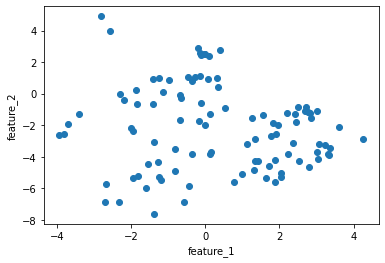

In [21]:
# Plot the learned 2-dimensional representations without labels
plt.scatter(encoded_arr[:, 0], encoded_arr[:, 1])
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.show()

In [22]:
# Recall the distinctive labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Here, we transform the first 100 tensor-formatted labels to the numpy-formatted labels, for plotting with matplotlib
y = train_data.targets[:100].numpy()
y
# y.size  # 100

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
       9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2,
       0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
       9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8])

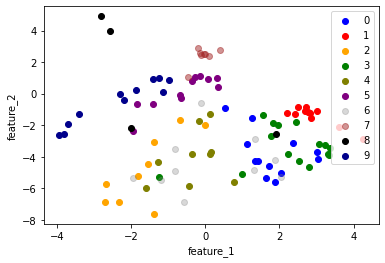

In [23]:
# Plot the learned 2-dimensional representations with labels
plt.scatter(encoded_arr[y == 0, 0], encoded_arr[y == 0, 1], label='0', c='blue')
plt.scatter(encoded_arr[y == 1, 0], encoded_arr[y == 1, 1], label='1', c='red')
plt.scatter(encoded_arr[y == 2, 0], encoded_arr[y == 2, 1], label='2', c='orange')
plt.scatter(encoded_arr[y == 3, 0], encoded_arr[y == 3, 1], label='3', c='green')
plt.scatter(encoded_arr[y == 4, 0], encoded_arr[y == 4, 1], label='4', c='olive')
plt.scatter(encoded_arr[y == 5, 0], encoded_arr[y == 5, 1], label='5', c='purple')
plt.scatter(encoded_arr[y == 6, 0], encoded_arr[y == 6, 1], label='6', c='grey', alpha=0.3)
plt.scatter(encoded_arr[y == 7, 0], encoded_arr[y == 7, 1], label='7', c='brown', alpha=0.5)
plt.scatter(encoded_arr[y == 8, 0], encoded_arr[y == 8, 1], label='8', c='black')
plt.scatter(encoded_arr[y == 9, 0], encoded_arr[y == 9, 1], label='9', c='darkblue')
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.legend()
plt.show()